In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import module

In [130]:
!pip install transformers --quiet

In [131]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

# Tạo các hàm tiền xử lý

In [132]:
# Đọc dữ liệu
ROOT_PATH = 'drive/MyDrive/dataset/vi_en_translation'
filename = 'translate.csv'
df = pd.read_csv(os.path.join(ROOT_PATH, filename), index_col=0)
df

,en,vi
0,"i asked for money for food, aunt asked for mon...","cháu đòi tiền cơm , dì đòi tiền nhà ."
1,da nang researches texting utility when violat...,đà nẵng nghiên_cứu tiện_ích nhắn_tin khi vi_ph...
2,confused about 70-year-old mother stealing dau...,khó xử vụ mẹ 70 tuổi trộm xe_hơi của con_gái .
3,changes in vehicle registration and transfer f...,"thay_đổi về đăng_ký , chuyển_nhượng xe từ 12/2..."
4,cases requiring expertise in economic cases.,những trường_hợp cần trưng_cầu giám_định trong...
...,...,...
8135,come to phu quoc to experience the world's lon...,đến phú quốc trải_nghiệm tuyết cáp_treo vượt b...
8136,prime minister nguyen xuan phuc and lao prime ...,thủ_tướng nguyễn xuân_phúc và thủ_tướng lào tớ...
8137,the story of the cable car installer.,chuyện về thợ lắp cáp_treo .
8138,"strengthen cooperation in science, technology ...","tăng_cường hợp_tác khoa_học , công_nghệ và viễ..."


In [133]:
MAX_LENGTH = 32

# Transformer with Decoder

### Tiền xử lý dữ liệu

In [134]:
from transformers import AutoTokenizer
# Tokenizer để encode đầu vào văn bản
vi_tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
en_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [135]:
en = list(df['en'].values)
vi = list(df['vi'].values)

In [136]:
en_ids = en_tokenizer(en, max_length=MAX_LENGTH, padding='max_length', truncation=True, return_attention_mask=False, return_token_type_ids=False).input_ids
vi_ids = vi_tokenizer(vi, max_length=MAX_LENGTH, padding='max_length', truncation=True, return_attention_mask=False, return_token_type_ids=False).input_ids

In [137]:
vi_ids[0], en_ids[0]

([0,
  575,
  1652,
  123,
  1412,
  4,
  9657,
  1652,
  123,
  69,
  5,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [101,
  1045,
  2356,
  2005,
  2769,
  2005,
  2833,
  1010,
  5916,
  2356,
  2005,
  2769,
  2005,
  1996,
  2160,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

# Model

In [138]:
# Các hàm quan trọng
# positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # sử dụng sin cho vị trí số chẵn trong mảng, 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # sử dụng cos cho vị trí số lẻ trong mảng, 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [139]:
# TokenEmbedding
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, 
                        input_vocab_size, # tokenizer.vocab_size
                        max_length): # max_seq_length - MAX_LENGTH
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_length, d_model)

    def call(self, x): # x(batch_size, input_seq_len)
        seq_len = tf.shape(x)[1]
        # cộng token embedding và position encoding.
        x = self.embedding(x)  # x(batch_size, input_seq_len, d_model), Input Embedding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        pos_enc = self.pos_encoding[:, :seq_len, :] # Positional Encoding   
        
        return x + pos_enc

In [140]:
# Encoder
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, 
                        num_heads, 
                        dff, 
                        rate=0.1):
        super(EncoderLayer, self).__init__()
        # sử dụng multi-head attention để tìm sự liên kết giữa các từ trong câu
        self.att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)

        self.ffn = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training):
        # sub layer 1
        attn_output = self.att(x, x)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        # sub layer 2
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        # return output
        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, 
                        d_model, 
                        num_heads, 
                        dff, 
                        rate):
        super().__init__()

        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

    def call(self, x, training=False): # (batch_size, input_seq_len)
        for i in range(self.num_layers):
              x = self.enc_layers[i](x, training)
        return x  # (batch_size, input_seq_len, d_model)


In [141]:
# Decoder 
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, # embedding_dimension
                    num_heads, 
                    dff, # feed_forward_dimension
                    rate):
        super().__init__()
        
        # Khởi tạo multihead Attention
        self.self_att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        self.enc_att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        # Linear FNN
        self.ffn = tf.keras.Sequential(
                [
                    tf.keras.layers.Dense(dff, activation="relu"),
                    tf.keras.layers.Dense(d_model),
                ]
            )
        
        # Add Norm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        # nếu ta sử dụng Multi-head attention trên cả câu như ở Encoder, 
        # Decoder sẽ nhận luôn từ tiếp theo mà nó cần dịch. Để ngăn điều đó, 
        # khi Decoder dịch đến từ thứ i, phần sau của câu sẽ bị che lại (masked) 
        # và Decoder chỉ được phép nhận thấy phần nó đã dịch trước đó.
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        # trả về mảng mới với các chiều dữ liệu mới dựa theo mult
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training=False):
        shape = tf.shape(target)
        batch_size = shape[0]
        seq_len = shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        # sub layer 1 (decoder self-attention)
        attn1 = self.self_att(target, target, attention_mask=causal_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + target) # Residual -> Norm

        # sub layer 2 (encoder - decoder attention)
        attn2 = self.enc_att(out1, enc_out)
        attn2 = self.dropout2(attn2, training=training)
        out2 =  self.layernorm2(attn2 + out1) # Residual -> Norm

        # sub layer 3
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm2(ffn_output + out2)   # Residual -> Norm
        # output decode out2
        return out3 

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,
                    d_model, # embedding_dimension
                    num_heads, 
                    dff, # feed_forward_dimension
                    rate):
        super().__init__()
        self.num_layers = num_layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
    def call(self, enc_out, target, training=False):
        for i in range(self.num_layers):
              target = self.dec_layers[i](enc_out, target)
        return target

In [142]:
class Transformer(tf.keras.Model):
    def __init__(self,
                d_model,           # dimension token embeddings
                num_heads,         # Số Attention Head
                dff,               # Số chiều của lớp feed forward
                num_layers_enc,     # Số lượng cá lớp encoder chồng lên nhau
                num_layers_dec,        # Số lượng cá lớp decoder chồng lên nhau
                source_max_length,        # MAX_LENGTH - maximum sequence length
                target_max_length,        # MAX_LENGTH - maximum sequence length
                input_vocab_size,  # vocab_size - Số lượng token có trong tokenizer (vocab size)
                output_vocab_size,  # vocab_size - Số lượng token có trong tokenizer (vocab size) (cũng là num class)
                rate  = 0.1             # dropout rate
        ):
        super().__init__()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")

        self.num_layers_dec = num_layers_dec
        self.num_layers_enc = num_layers_enc

        self.source_maxlen = source_max_length
        self.target_maxlen = target_max_length
        
        # Khởi tạo tầng Embedding
        self.enc_input = TokenEmbedding(
            d_model, 
            input_vocab_size, # tokenizer.vocab_size
            source_max_length
        )
        self.dec_input = TokenEmbedding(
            d_model, 
            output_vocab_size, # tokenizer.vocab_size
            target_max_length
        )

        # Khởi tạo các lớp decoder và encoder chồng lên nhau
        self.encoder = Encoder(num_layers_enc, d_model, num_heads, dff, rate=0.1)
        self.decoder = Decoder(num_layers_dec, d_model, num_heads, dff, rate=0.1)

        # Khởi tạo lớp đầu ra
        self.output_vocab_size = output_vocab_size
        self.classifier = tf.keras.layers.Dense(output_vocab_size)

    def encode(self, source):
        x = self.enc_input(source) # pisitional encoding & embeding
        x = self.encoder(x) # encode output
        return x
    def decode(self, enc_out, target):
        # Dự đoán từng từ trong câu
        y = self.dec_input(target) # pisitional encoding & embeding
        y = self.decoder(enc_out, y) # decode output
        return y

    def call(self, inputs): 
        source = inputs[0]
        target = inputs[1]
        x = self.encode(source) # encode output
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    # Hàm train model
    def train_step(self, batch): 
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.output_vocab_size)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_ids):
        # Thực hiện suy luận trên một loạt đầu vào (batch of input) bằng cách sử dụng giải thuật greedy
        # seq_len = tf.shape(x)[1]
        enc = self.encode(source)

        bs = tf.shape(source)[0]
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_ids
        for _ in range(self.target_maxlen-1): # self.target_maxlen - seq_len
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            # logits là giá trị từ tiếp theo của n từ trước nó
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


In [143]:
# Khởi tạo model
model = Transformer(
    d_model = 256 ,        
    num_heads = 4  ,
    dff = 256*4,
    num_layers_enc = 8,
    num_layers_dec = 8,
    source_max_length = MAX_LENGTH,
    target_max_length = MAX_LENGTH,
    input_vocab_size = vi_tokenizer.vocab_size,
    output_vocab_size = en_tokenizer.vocab_size,
    rate  = 0.1 
)

In [144]:
BATCH_SIZE = 64

In [145]:
vi_slices = tf.data.Dataset.from_tensor_slices(vi_ids)
en_slices = tf.data.Dataset.from_tensor_slices(en_ids)

data = tf.data.Dataset.zip((vi_slices, en_slices))
data = data.map(lambda x, y: {"source": x, "target": y})
data = data.batch(BATCH_SIZE)
data = data.prefetch(tf.data.AUTOTUNE)

In [146]:
# Khởi tạo hàm lỗi
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)
# Khởi tạo thuật toán tối ưu Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
# Compile và fit model với 200 epochs
model.compile(optimizer=optimizer, loss=loss_fn)
history = model.fit(data, epochs=100) 

Epoch 1/100
128/128 [==============================] - 122s 435ms/step - loss: 4.8982
Epoch 2/100
128/128 [==============================] - 34s 263ms/step - loss: 4.1962
Epoch 3/100
128/128 [==============================] - 33s 259ms/step - loss: 3.8395
Epoch 4/100
128/128 [==============================] - 33s 261ms/step - loss: 3.6650
Epoch 5/100
128/128 [==============================] - 34s 262ms/step - loss: 3.5444
Epoch 6/100
128/128 [==============================] - 34s 261ms/step - loss: 3.4476
Epoch 7/100
128/128 [==============================] - 34s 262ms/step - loss: 3.3631
Epoch 8/100
128/128 [==============================] - 34s 262ms/step - loss: 3.2762
Epoch 9/100
128/128 [==============================] - 34s 263ms/step - loss: 3.1922
Epoch 10/100
128/128 [==============================] - 33s 261ms/step - loss: 3.1147
Epoch 11/100
128/128 [==============================] - 33s 261ms/step - loss: 3.0469
Epoch 12/100
128/128 [==============================] - 34s 26

In [147]:
# model.save_weights('./my_checkpoint')

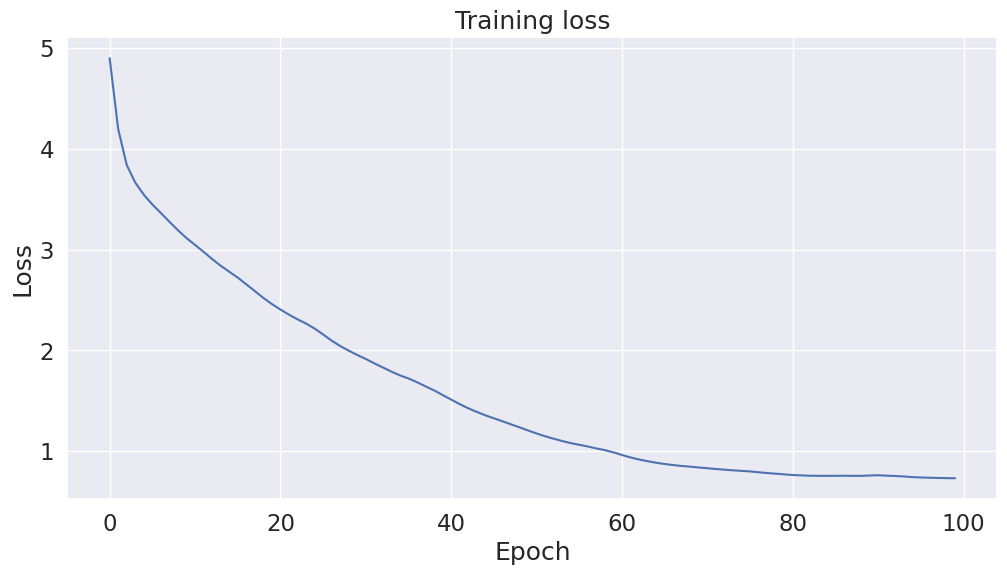

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

values = history.history['loss'] 
# Use plot styling from seaborn.  
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(values , 'b')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [159]:
idx = 8

text_input = vi[idx:idx+1]
input_ids = tf.convert_to_tensor(vi_tokenizer(text_input).input_ids)

token_generate = model.generate(input_ids[:,:-1], 101) # bỏ </s>
text_generated = en_tokenizer.decode(token_generate[0]) # SEP sẽ đại diện cho ký tự kết thúc câu

print(vi_tokenizer.decode(input_ids[0]))
print()
print(text_generated)

<s> cái kết đắng_chát sau 20 năm đám_cưới là lời tuyên_bố của chồng tệ_bạc :'giải_tán đi, tôi lấy vợ khác '. </s>

[CLS] the bitter ending after 20 years of marriage is the declaration of a bad husband : wouldisbanded, i will get another wife '. [SEP]'[SEP]
